This notebook explains how we can go about explore and prepare data for model building.The notebook is structured in the following way 

 - About Dataset
 - Data Summary
 - univariate analysis
 - Correlation Analysis
 - Feature Engineering
 - Visualizing Count Vs (Month,Season,Hour,Weekday)
 - Preprocessing 
 - Model Building
 - PCA
 - TUNING HYPERPARAMETERS USING GRIDSEARCH

## About Dataset (BIKE SHARING DEMAND)

#### **Overview**

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

#### **Data Fields**

* datetime - hourly date + timestamp  
* season -  spring, summer,fall,winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather 
            *' Clear + Few clouds' 
            *' Light Snow, Light Rain'
            *' Mist + Cloudy '
            *' Heavy Rain + Thunderstorm '
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* count - number of total rentals (Dependent Variable)

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings("ignore")

In [163]:
# x is independent features 
# y is dependent feature(label)
X_train = pd.read_csv(r"E:\nitw\project\bikesharing\Dataset\train.csv")
X_test = pd.read_csv(r"E:\nitw\project\bikesharing\Dataset\test.csv")
y_train = pd.read_csv(r"E:\nitw\project\bikesharing\Dataset\train_label.csv",header=None,names=["count"])
y_test = pd.read_csv(r"E:\nitw\project\bikesharing\Dataset\test_label.csv",header=None)

In [164]:
df = pd.concat([X_train , y_train], axis=1) #df is training data
df_copy =df.copy()

In [165]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,5/2/2012 19:00,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504
1,9/5/2012 4:00,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5
2,1/13/2011 9:00,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139
3,11/18/2011 16:00,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209
4,9/13/2011 13:00,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184


## Univariate analysis

In [166]:
df.season.value_counts()

Summer    2197
Fall      2189
Winter    2186
Spring    2136
Name: season, dtype: int64

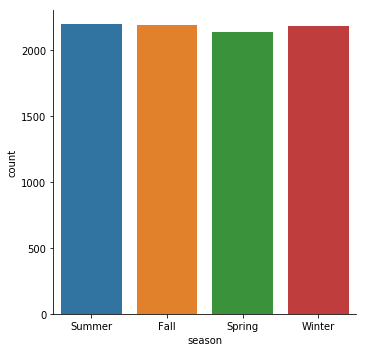

In [167]:
sns.factorplot(x='season',data=df,kind='count',size=5,aspect=1)

In [168]:
#holiday
df.holiday.value_counts()

0    8460
1     248
Name: holiday, dtype: int64

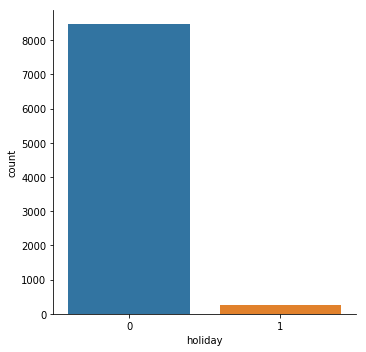

In [169]:
sns.factorplot(x='holiday',data=df,kind='count',size=5,aspect=1)

In [170]:
#weather
df.weather.value_counts()

 Clear + Few clouds            5753
 Mist + Cloudy                 2276
 Light Snow, Light Rain         678
 Heavy Rain + Thunderstorm        1
Name: weather, dtype: int64

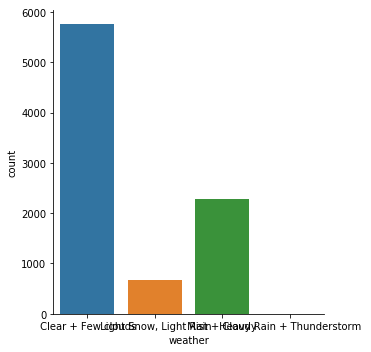

In [171]:
sns.factorplot(x='weather',data=df,kind='count',size=5,aspect=1)

## Correlation Analysis

One common to understand how a dependent variable is influenced by features (numerical) is to fibd a correlation matrix between them. Lets plot a correlation plot between "count" and ["temp","atemp","humidity","windspeed"].

 - temp and humidity features has got positive and negative correlation
   with count respectively.Although the correlation between them are not
   very prominent still the count variable has got little dependency on
   "temp" and "humidity".
 - windspeed is not gonna be really useful numerical feature and it is visible from it correlation value with "count"
 - "atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.

Regression plot in seaborn is one useful way to depict the relationship between two features. Here we consider "count" vs "temp", "humidity", "windspeed".

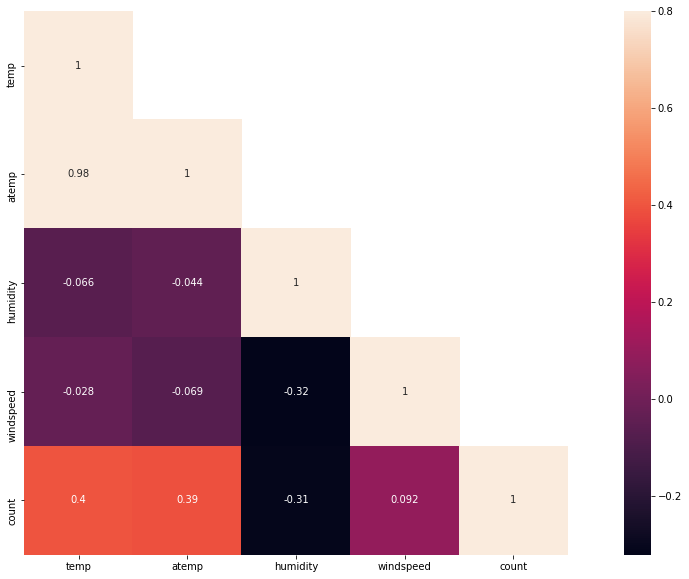

In [172]:
corrMatt = df[["temp","atemp","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

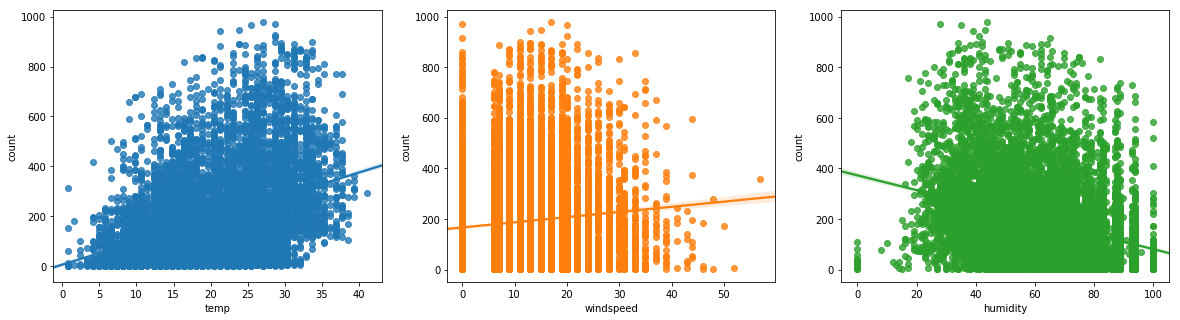

In [173]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(20, 5)
sn.regplot(x="temp", y="count", data=df,ax=ax1)
sn.regplot(x="windspeed", y="count", data=df,ax=ax2)
sn.regplot(x="humidity", y="count", data=df,ax=ax3)

## Feature Engineering

As we see from the above results, the columns "season","holiday","workingday" and "weather" should be of "categorical" data type.But the current data type is "int" for those columns. Let us transform the dataset in the following ways so that we can get started up with our EDA

 - Create new columns "date,"hour","weekDay","month" from "datetime"
   column.
 - Coerce the datatype of "season","holiday","workingday" and weather to category.
 - Drop the datetime column as we already extracted useful features from it.

In [174]:
import calendar
from datetime import datetime
df["date"] = df.datetime.apply(lambda x : x.split()[0])
df["hour"] = df.datetime.apply(lambda x : x.split()[1].split(":")[0])
df["weekday"] = df.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%m/%d/%Y").weekday()])
df["month"] = df.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%m/%d/%Y").month])

In [175]:
df["hour"] = df["hour"].apply(lambda x: x.zfill(2))

In [176]:
df = df.drop(["datetime"],axis=1)

In [177]:
df.head(10)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,date,hour,weekday,month
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,5/2/2012,19,Wednesday,May
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,9/5/2012,04,Wednesday,September
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,1/13/2011,09,Thursday,January
3,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209,11/18/2011,16,Friday,November
4,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184,9/13/2011,13,Tuesday,September
5,Fall,0,1,Clear + Few clouds,33.62,12.120,36,22.0028,791,8/17/2012,17,Friday,August
6,Winter,0,0,Clear + Few clouds,24.60,29.545,73,12.9980,395,10/6/2012,09,Saturday,October
7,Fall,0,1,Clear + Few clouds,21.32,25.000,68,19.0012,5,9/10/2012,04,Monday,September
8,Fall,0,0,"Light Snow, Light Rain",27.06,31.060,61,7.0015,9,7/14/2012,04,Saturday,July
9,Spring,0,0,Clear + Few clouds,12.30,15.150,56,11.0014,78,2/6/2011,18,Sunday,February


In [178]:
dailyData.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
date          0
hour          0
weekday       0
month         0
dtype: int64

## Visualizing Count Vs (Month,Season,Hour,Weekday)

 - It is quiet obvious that people tend to rent bike during summer
   season since it is really conducive to ride bike at that
   season.Therefore June, July and August has got relatively higher
   demand for bicycle.
 - On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
 - Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Weekdays'),
 None]

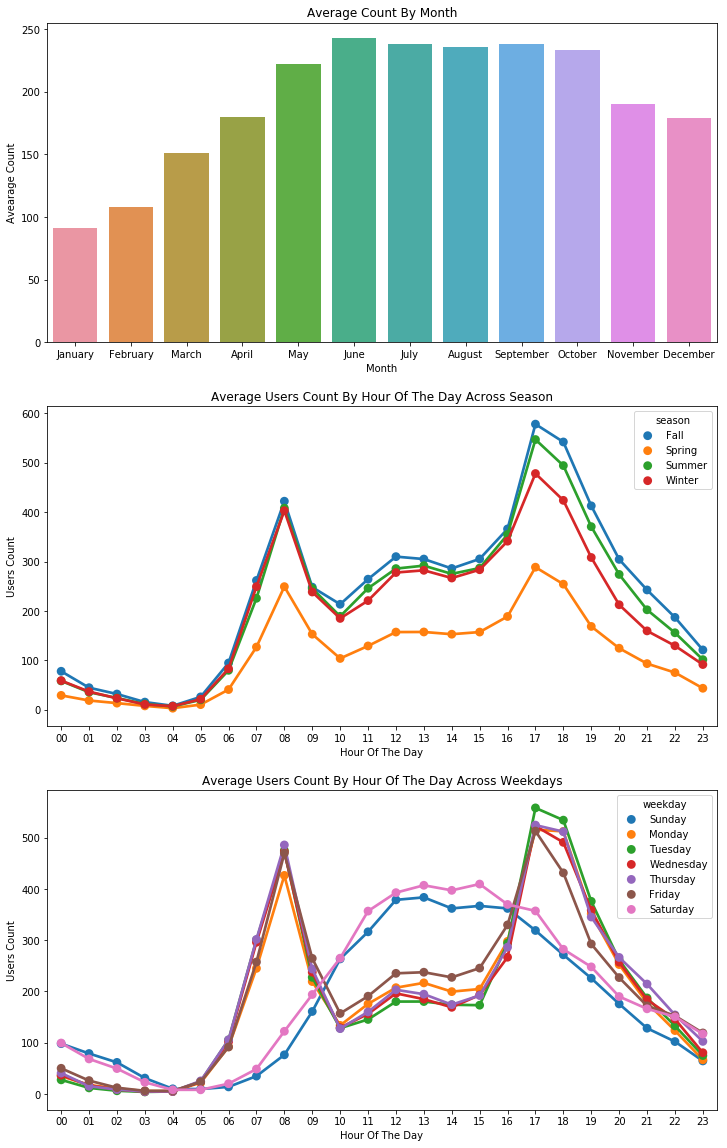

In [179]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(df.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(df.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(df.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

In [144]:
data = df_copy.append(X_test)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

In [145]:
data.tail()

,atemp,count,datetime,holiday,humidity,season,temp,weather,windspeed,workingday
10881,22.725,NaN,3/8/2012 3:00,0,63,Spring,18.86,Clear + Few clouds,26.0027,1
10882,17.425,NaN,1/12/2012 12:00,0,81,Spring,13.94,Mist + Cloudy,7.0015,1
10883,22.725,NaN,3/7/2012 22:00,0,59,Spring,18.86,Clear + Few clouds,19.9995,1
10884,21.210,NaN,5/12/2011 5:00,0,94,Summer,17.22,Clear + Few clouds,8.9981,1
10885,34.850,NaN,7/18/2012 16:00,0,66,Fall,30.34,Clear + Few clouds,16.9979,1


In [124]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("/")[2])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%m/%d/%Y").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%m/%d/%Y").month)

In [125]:
data.head()

,atemp,count,datetime,holiday,humidity,season,temp,weather,windspeed,workingday,date,hour,year,weekday,month
0,25.760,504.0,5/2/2012 19:00,0,77,Summer,22.14,Clear + Few clouds,16.9979,1,5/2/2012,19,2012,2,5
1,33.335,5.0,9/5/2012 4:00,0,79,Fall,28.70,Clear + Few clouds,19.0012,1,9/5/2012,4,2012,2,9
2,6.060,139.0,1/13/2011 9:00,0,50,Spring,5.74,Clear + Few clouds,22.0028,1,1/13/2011,9,2011,3,1
3,16.665,209.0,11/18/2011 16:00,0,29,Winter,13.94,Clear + Few clouds,8.9981,1,11/18/2011,16,2011,4,11
4,33.335,184.0,9/13/2011 13:00,0,51,Fall,30.34,Clear + Few clouds,19.0012,1,9/13/2011,13,2011,1,9


## Preprocessing 

In [126]:
from sklearn.preprocessing import minmax_scale
data[['atemp','humidity','temp','windspeed']] = minmax_scale(data[['atemp','humidity','temp','windspeed']])

In [127]:
data.head()

,atemp,count,datetime,holiday,humidity,season,temp,weather,windspeed,workingday,date,hour,year,weekday,month
0,0.559347,504.0,5/2/2012 19:00,0,0.77,Summer,0.530612,Clear + Few clouds,0.298225,1,5/2/2012,19,2012,2,5
1,0.728829,5.0,9/5/2012 4:00,0,0.79,Fall,0.693878,Clear + Few clouds,0.333373,1,9/5/2012,4,2012,2,9
2,0.118581,139.0,1/13/2011 9:00,0,0.50,Spring,0.122449,Clear + Few clouds,0.386035,1,1/13/2011,9,2011,3,1
3,0.355856,209.0,11/18/2011 16:00,0,0.29,Winter,0.326531,Clear + Few clouds,0.157870,1,11/18/2011,16,2011,4,11
4,0.728829,184.0,9/13/2011 13:00,0,0.51,Fall,0.734694,Clear + Few clouds,0.333373,1,9/13/2011,13,2011,1,9


In [129]:
data_dummy = data

def dummify_dataset(df, column):       
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column, drop_first=True)],axis=1)
    df = df.drop([column], axis=1)
    return df

columns_to_dummify = ['season', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather']
for column in columns_to_dummify:
    data_dummy = dummify_dataset(data_dummy, column)

In [130]:
data_dummy.head()

,atemp,count,datetime,humidity,temp,windspeed,date,year,season_Spring,season_Summer,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weather_ Heavy Rain + Thunderstorm,"weather_ Light Snow, Light Rain",weather_ Mist + Cloudy
0,0.559347,504.0,5/2/2012 19:00,0.77,0.530612,0.298225,5/2/2012,2012,0,1,...,0,1,0,0,0,0,1,0,0,0
1,0.728829,5.0,9/5/2012 4:00,0.79,0.693878,0.333373,9/5/2012,2012,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0.118581,139.0,1/13/2011 9:00,0.50,0.122449,0.386035,1/13/2011,2011,1,0,...,0,0,1,0,0,0,1,0,0,0
3,0.355856,209.0,11/18/2011 16:00,0.29,0.326531,0.157870,11/18/2011,2011,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0.728829,184.0,9/13/2011 13:00,0.51,0.734694,0.333373,9/13/2011,2011,0,0,...,1,0,0,0,0,0,1,0,0,0


In [146]:
traindata = data_dummy[pd.notnull(data['count'])]
testdata = data_dummy[~pd.notnull(data['count'])]
traindata.reset_index(drop=True)

,atemp,count,datetime,humidity,temp,windspeed,date,year,season_Spring,season_Summer,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weather_ Heavy Rain + Thunderstorm,"weather_ Light Snow, Light Rain",weather_ Mist + Cloudy
0,0.559347,504.0,5/2/2012 19:00,0.77,0.530612,0.298225,5/2/2012,2012,0,1,...,0,1,0,0,0,0,1,0,0,0
1,0.728829,5.0,9/5/2012 4:00,0.79,0.693878,0.333373,9/5/2012,2012,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0.118581,139.0,1/13/2011 9:00,0.50,0.122449,0.386035,1/13/2011,2011,1,0,...,0,0,1,0,0,0,1,0,0,0
3,0.355856,209.0,11/18/2011 16:00,0.29,0.326531,0.157870,11/18/2011,2011,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0.728829,184.0,9/13/2011 13:00,0.51,0.734694,0.333373,9/13/2011,2011,0,0,...,1,0,0,0,0,0,1,0,0,0
5,0.254167,791.0,8/17/2012 17:00,0.36,0.816327,0.386035,8/17/2012,2012,0,0,...,0,0,0,1,0,0,1,0,0,0
6,0.644032,395.0,10/6/2012 9:00,0.73,0.591837,0.228047,10/6/2012,2012,0,0,...,0,0,0,0,1,0,0,0,0,0
7,0.542343,5.0,9/10/2012 4:00,0.68,0.510204,0.333373,9/10/2012,2012,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0.677928,9.0,7/14/2012 4:00,0.61,0.653061,0.122840,7/14/2012,2012,0,0,...,0,0,0,0,1,0,0,0,1,0
9,0.321960,78.0,2/6/2011 18:00,0.56,0.285714,0.193018,2/6/2011,2011,1,0,...,0,0,0,0,0,1,0,0,0,0


**Dropping  Unncessary Variables**

In [147]:
X_new_train = traindata.drop(["count","datetime","date"],axis=1)#X_new_train IS NORMALIZED X_train
X_new_test = testdata.drop(["count","datetime","date"],axis=1)#X_new_test is NORMALIZED X_test

In [148]:
X_new_train.head()

,atemp,humidity,temp,windspeed,year,season_Spring,season_Summer,season_Winter,month_2,month_3,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weather_ Heavy Rain + Thunderstorm,"weather_ Light Snow, Light Rain",weather_ Mist + Cloudy
0,0.559347,0.77,0.530612,0.298225,2012,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0.728829,0.79,0.693878,0.333373,2012,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0.118581,0.50,0.122449,0.386035,2011,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,0.355856,0.29,0.326531,0.157870,2011,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0.728829,0.51,0.734694,0.333373,2011,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [150]:
X_new_test.head()

,atemp,humidity,temp,windspeed,year,season_Spring,season_Summer,season_Winter,month_2,month_3,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weather_ Heavy Rain + Thunderstorm,"weather_ Light Snow, Light Rain",weather_ Mist + Cloudy
8708,0.542343,0.48,0.510204,0.614083,2012,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
8709,0.593243,0.64,0.571429,0.122840,2012,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8710,0.254167,1.00,0.265306,0.491243,2011,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
8711,0.627140,0.83,0.612245,0.000000,2011,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
8712,0.677928,0.43,0.612245,0.421065,2012,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Model building

In [37]:
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error # for regression

In [151]:
models=[RandomForestRegressor(),AdaBoostRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','SVR','KNeighborsRegressor']
rmsle=[]
d={}
for model in range (len(models)):
    clf=models[model] 
    clf.fit(X_new_train,y_train)
    test_pred=clf.predict(X_new_test)
    rmsle.append(np.sqrt(mean_squared_log_error(test_pred,y_test)))
d={'Modelling Algo':model_names,'RMSLE':rmsle}  

In [152]:
rmsle_frame=pd.DataFrame(d)
rmsle_frame

,Modelling Algo,RMSLE
0,RandomForestRegressor,0.527899
1,AdaBoostRegressor,1.572483
2,SVR,1.397361
3,KNeighborsRegressor,0.719061


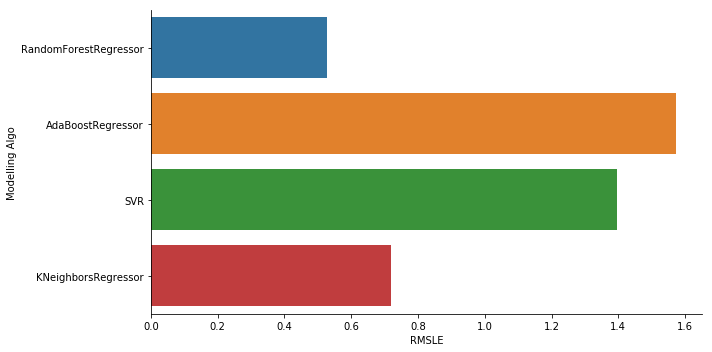

In [153]:
import seaborn as sns
sns.factorplot(y='Modelling Algo',x='RMSLE',data=rmsle_frame,kind='bar',size=5,aspect=2)

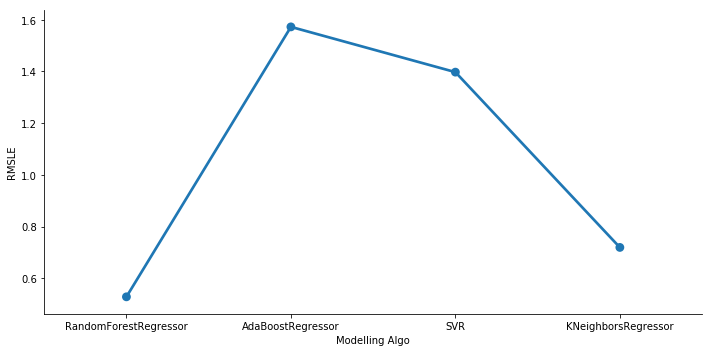

In [154]:
sns.factorplot(x='Modelling Algo',y='RMSLE',data=rmsle_frame,kind='point',size=5,aspect=2)

####  NOW RANDOM FORETS REGRESSOR GIVES THE LEAST RMSLE.

## PCA

- we can get rid of features that are not important for the model. This is called dimensionality reduction.
- For dimensionality reduction, we can use a linear technique called principal component analysis (PCA)
- we have plotted a graph to explain the variance of the data by the number of variables. Our goal is to find a “break point” on the graph that will correspond to our optimal number of variables.

Text(0, 0.5, 'Explained variance')

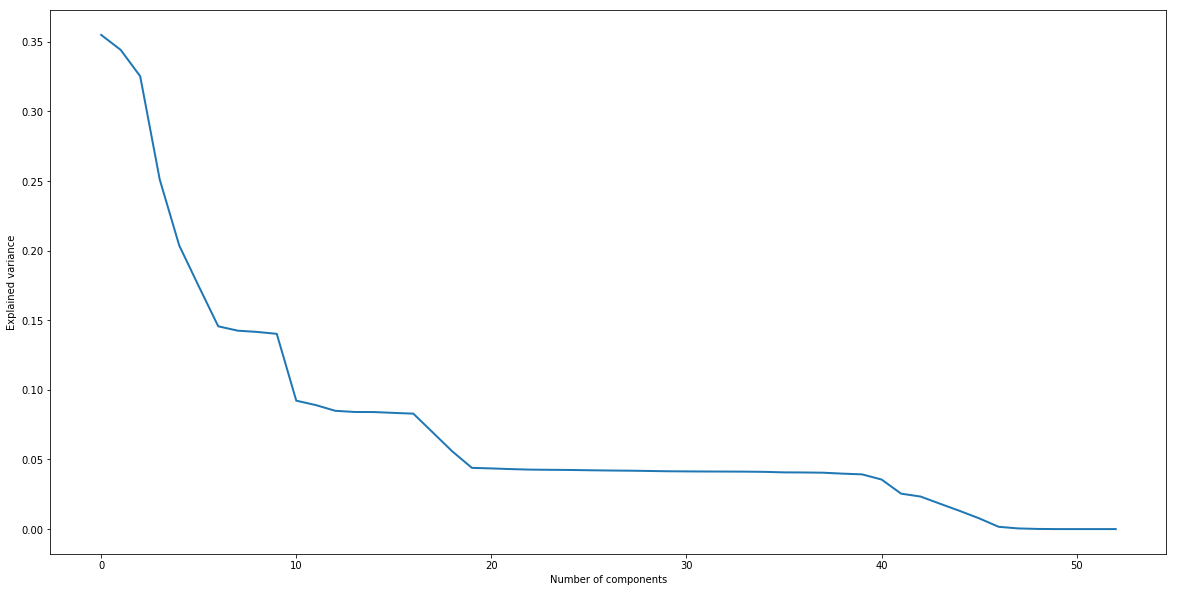

In [155]:
from sklearn.decomposition import PCA
# Plot PCA spectrum
pca = PCA()
pca.fit(X_new_train)
plt.figure(1, figsize=(20, 10))
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

**PIPELINE**

In [46]:
from sklearn.pipeline import Pipeline
rfr = RandomForestRegressor()
pipeline = Pipeline(steps=[('pca', pca),('rfr', rfr)])

## TUNING HYPERPARAMETERS USING GRIDSEARCH

In [156]:
from sklearn.model_selection import GridSearchCV
hyperparameters = {"rfr__n_estimators": [10,20,30],
            "rfr__max_features": ["auto", "sqrt", "log2"],
            "rfr__min_samples_split": [2,4,8],
            "rfr__bootstrap": [True, False],'pca__n_components': [10,20,40]}
clf1 = GridSearchCV(pipeline,hyperparameters,cv=5)

In [49]:
clf1.fit(X_new_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rfr', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decreas...s='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'rfr__n_estimators': [10, 20, 30], 'rfr__max_features': ['auto', 'sqrt', 'log2'], 'rfr__min_samples_split': [2, 4, 8], 'rfr__bootstrap': [True, False], 'pca__n_components': [10, 20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [160]:
clf1.best_params_

{'pca__n_components': 40,
 'rfr__bootstrap': False,
 'rfr__max_features': 'sqrt',
 'rfr__min_samples_split': 4,
 'rfr__n_estimators': 30}

In [53]:
import pickle
with open ("randomforestregressor.pickle","wb") as f:
    pickle.dump(clf1,f)

In [159]:
pickle_in = open ("randomforestregressor.pickle","rb")
clf1 = pickle.load(pickle_in)

In [55]:
y_pred = clf1.predict(dataTest)

In [161]:
print ("RMSLE Value For RandomForestRegressor AFTER PCA: ",np.sqrt(mean_squared_log_error(y_pred,y_test)))

RMSLE Value For RandomForestRegressor AFTER PCA:  0.4633864733878935
